In [1]:
!pip install parameter-sherpa

In [1]:
import sherpa

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
data = pd.read_csv("owid-covid-data.csv")
data = data[data.iso_code=="FRA"]
data = data[data.date>='2020-01-24'] # primeiro caso computado
data.reset_index(inplace=True)

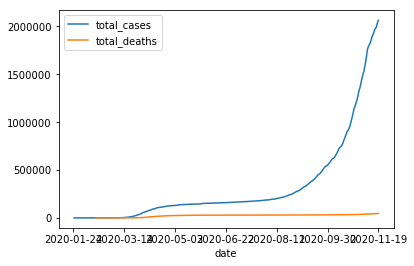

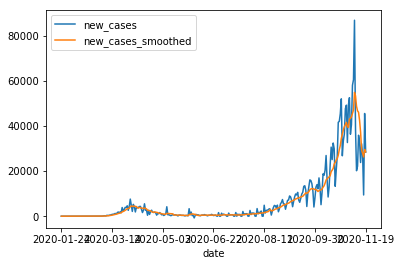

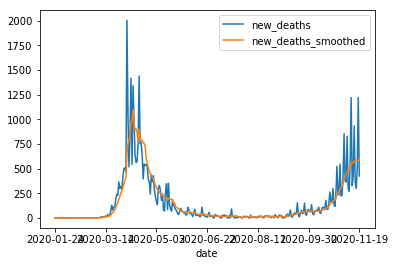

In [17]:
data.set_index('date')[['total_cases','total_deaths']].plot()
data.set_index('date')[['new_cases','new_cases_smoothed']].plot()
data.set_index('date')[['new_deaths','new_deaths_smoothed']].plot()
popFRA = 67*10^6 

In [31]:
def ODE (t,y,params):
    S,E,I,A,R,D = y
    lambda_,alpha,p,theta,gamma, mu,mu1,mu2, t1,t2 = params

    # transição de mu1 para mu2, mudança de perfil dos infectados, com inflexão em t2, flexibilização do Lockdown
    mu = ( ( (np.tanh(-t + t2) + 1 )/2 ) * abs(mu1 - mu2) ) + mu2
    
    # período de isolamento com queda de lambda_ com inflexões em t1 e t2, início e fim do lockdown respectivamente
    lambda_ = lambda_ * (1 - ((1 + np.tanh(t - t1)) / 2) * ((1 - np.tanh(t - t2) / 2) ) )
    
    return [-lambda_*S*I,
            lambda_*S*I - alpha*E,
            (1-p)*alpha*E - gamma*I - mu*I,
            p*alpha*E - theta*A,
            gamma*I + theta*A,
            mu*I ]

In [32]:
T = ode_solver()
T.function = ODE
T.algorithm='rk8pd'
inits = [.99, 0, 0.0001, 0, 0, 0]
tspan = [0,len(data)]
T.ode_solve(tspan, inits, num_points=len(data), params=[0.1,0.1,0.1,0.1,0.4,0.1,0.1,0.1,54,109])

In [33]:
T.solution[0][1][0]

0.990000000000000

In [21]:
def get_sim_array(sol):
    sim = np.array([y for t,y in sol])
    return sim
get_sim_array(T.solution)

array([[9.90000000e-01, 0.00000000e+00, 1.00000000e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [9.89992198e-01, 7.39400226e-06, 6.09634501e-05, 3.93982822e-08,
        3.15243113e-05, 7.88073016e-06],
       [9.89987415e-01, 1.12241980e-05, 3.76624347e-05, 1.26661327e-07,
        5.08595009e-05, 1.27125128e-05],
       ...,
       [9.89975907e-01, 1.29310453e-15, 2.76333540e-16, 6.10087060e-16,
        9.97563392e-05, 2.43367574e-05],
       [9.89975907e-01, 1.19506611e-15, 2.55382949e-16, 5.63854736e-16,
        9.97563392e-05, 2.43367574e-05],
       [9.89975907e-01, 1.10446059e-15, 2.36020754e-16, 5.21125462e-16,
        9.97563392e-05, 2.43367574e-05]])

In [22]:
parameters = [
    sherpa.Continuous(name='lambda_',range=[.7,1.2]), 
    sherpa.Continuous(name='alpha',range=[.01,.09]), 
    sherpa.Continuous(name='p',range=[.4,0.5]),
    sherpa.Continuous(name='theta',range=[.6,.9]),
    sherpa.Continuous(name='gamma',range=[.1,.5]),
    sherpa.Continuous(name='mu',range=[.01,.1]),
    sherpa.Continuous(name='mu1',range=[.01,.1]),
    sherpa.Continuous(name='mu2',range=[.01,.1]),
    sherpa.Discrete(name='t2',range=[100,120]), # quando a flexibilização afetou a dinâmica
    sherpa.Discrete(name='t1',range=[40,60]), # quando o isolamento afetou a dinâmica 
]
algorithm = sherpa.algorithms.RandomSearch(max_num_trials=1000)

In [23]:
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=True,
                     disable_dashboard=True)

In [24]:
trial = study.get_suggestion()
trial.parameters

{'lambda_': 0.878458447714995,
 'alpha': 0.013932716751248346,
 'p': 0.4099234926726237,
 'theta': 0.8624822111873607,
 'gamma': 0.1975863494117982,
 'mu': 0.07541465918190389,
 'mu1': 0.04639704068587566,
 'mu2': 0.03858451865766152,
 't2': 100,
 't1': 55}

In [25]:
for trial in study:
    pars = [trial.parameters[n] for n in ['lambda_', 'alpha','p','theta','gamma', 'mu','mu1','mu2','t1','t2' ]]
    
    T.ode_solve(tspan, inits, num_points=len(data), params=pars)
    sim = get_sim_array(T.solution)
    
    I = sim[:,-4]
    D = sim[:,-1]
    
    SEQcases = sum( ( data.total_cases/popFRA - I[ : len(data)] )**2 ) /2*len(data)
    SEQdeaths = sum( ( data.total_deaths/popFRA - D[ : len(data)] )**2 ) /2*len(data)
    
    
    study.add_observation(trial=trial,
                          objective=SEQcases + SEQdeaths,
                          )
    study.finalize(trial)

In [26]:
res = study.get_best_result()
res

{'Trial-ID': 116,
 'Iteration': 1,
 'alpha': 0.029311071794789756,
 'gamma': 0.25132732342467623,
 'lambda_': 0.9527055425182938,
 'mu': 0.018984338994413742,
 'mu1': 0.014227433164825644,
 'mu2': 0.01316882000602942,
 'p': 0.41916363340813906,
 't1': 52,
 't2': 109,
 'theta': 0.8537118253743408,
 'Objective': 1.4174105479423693}

In [27]:
def plot_results(pars):
    
    T.ode_solve(tspan, inits, num_points= len(data), params = list(pars) )
    sim = get_sim_array(T.solution)
    
    i = list_plot(sim[:len(data),-2],color='red',legend_label='I', plotjoined=True)
    d = list_plot(sim[:len(data),-1],color='purple', legend_label='D', plotjoined=True)
    
    cases = list_plot(list(zip(range(1,len(data)),data.total_cases/popFRA)), color='black',legend_label='cases(obs)')
    deaths = list_plot(list(zip(range(1,len(data)),data.total_deaths/popFRA)), color='orange',legend_label='deaths(obs)')
    
    show(i+cases)
    show(d+deaths)

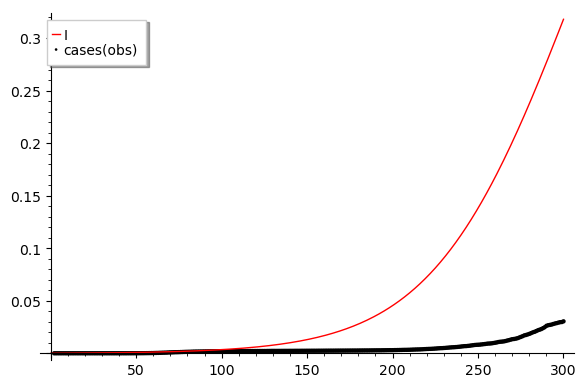

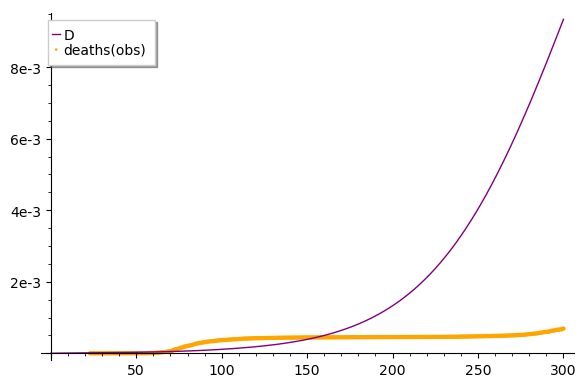

In [28]:
plot_results([res['lambda_'],
              res['alpha'],
              res['p'],
              res['theta'],
              res['gamma'],
              res['mu'],
              res['mu1'],
              res['mu2'],
              res['t1'],
              res['t2'],
             ])

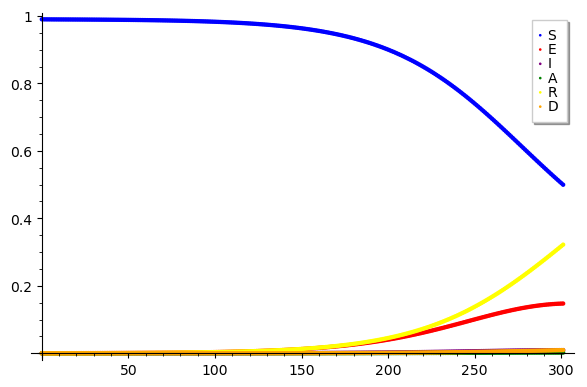

In [29]:
def plot_sol(sol):
    sim = get_sim_array(sol)
    P = list_plot(sim[:,0],legend_label='S')
    colors = ['blue','red','purple','green','yellow','orange']
    for i,var in enumerate(['E','I','A','R','D']):
        P += list_plot(sim[:,i+1],color=colors[i+1],legend_label=var)
   
    show(P)
plot_sol(T.solution)